<div align="center">
    <h1>Aprendizaje automático</h1>
    <h3>Fundamentos y aplicaciones en meteorología del espacio</h3>
    <h4>TP 2: Predicción</h4>
    <h5>Alumno: Federico Iza</h5>
</div>

# Predicción de series temporales

In [1]:
import pandas as pd
from tp2_settings import *
import matplotlib.pyplot as plt
from utils.plot import config_plots
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers.core import Dense
import matplotlib.dates as mdates
import datetime

2022-08-31 16:58:47.430045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-31 16:58:47.430066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
config_plots()

## Adquisición de datos

In [3]:
# Read data with selected columns
df = pd.read_csv('../data/sym_h_reduced.csv',
                 usecols=['timestamp', 'SYM-H'])

# Rename columns
df.rename(columns={'timestamp': 'Timestamp'}, inplace=True)

# Transform string to datetime format
date_format = '%Y-%m-%d %H:%M:%S'
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format=date_format)

In [4]:
df.head()

,Timestamp,SYM-H
0,2013-02-01 00:00:00,-10.0
1,2013-02-01 00:01:00,-10.0
2,2013-02-01 00:02:00,-10.0
3,2013-02-01 00:03:00,-10.0
4,2013-02-01 00:04:00,-10.0


In [5]:
def add_latex_minus(x: float) -> str:
    """
    Transforms a float into a latex-formated string in the case a minus
    is present.

    :param x: A float to transform into a string.
    :return: A string with the correct minus sign.
    """
    s = f'$-${np.abs(x)}' if x < 0 else f'{x}'
    return s

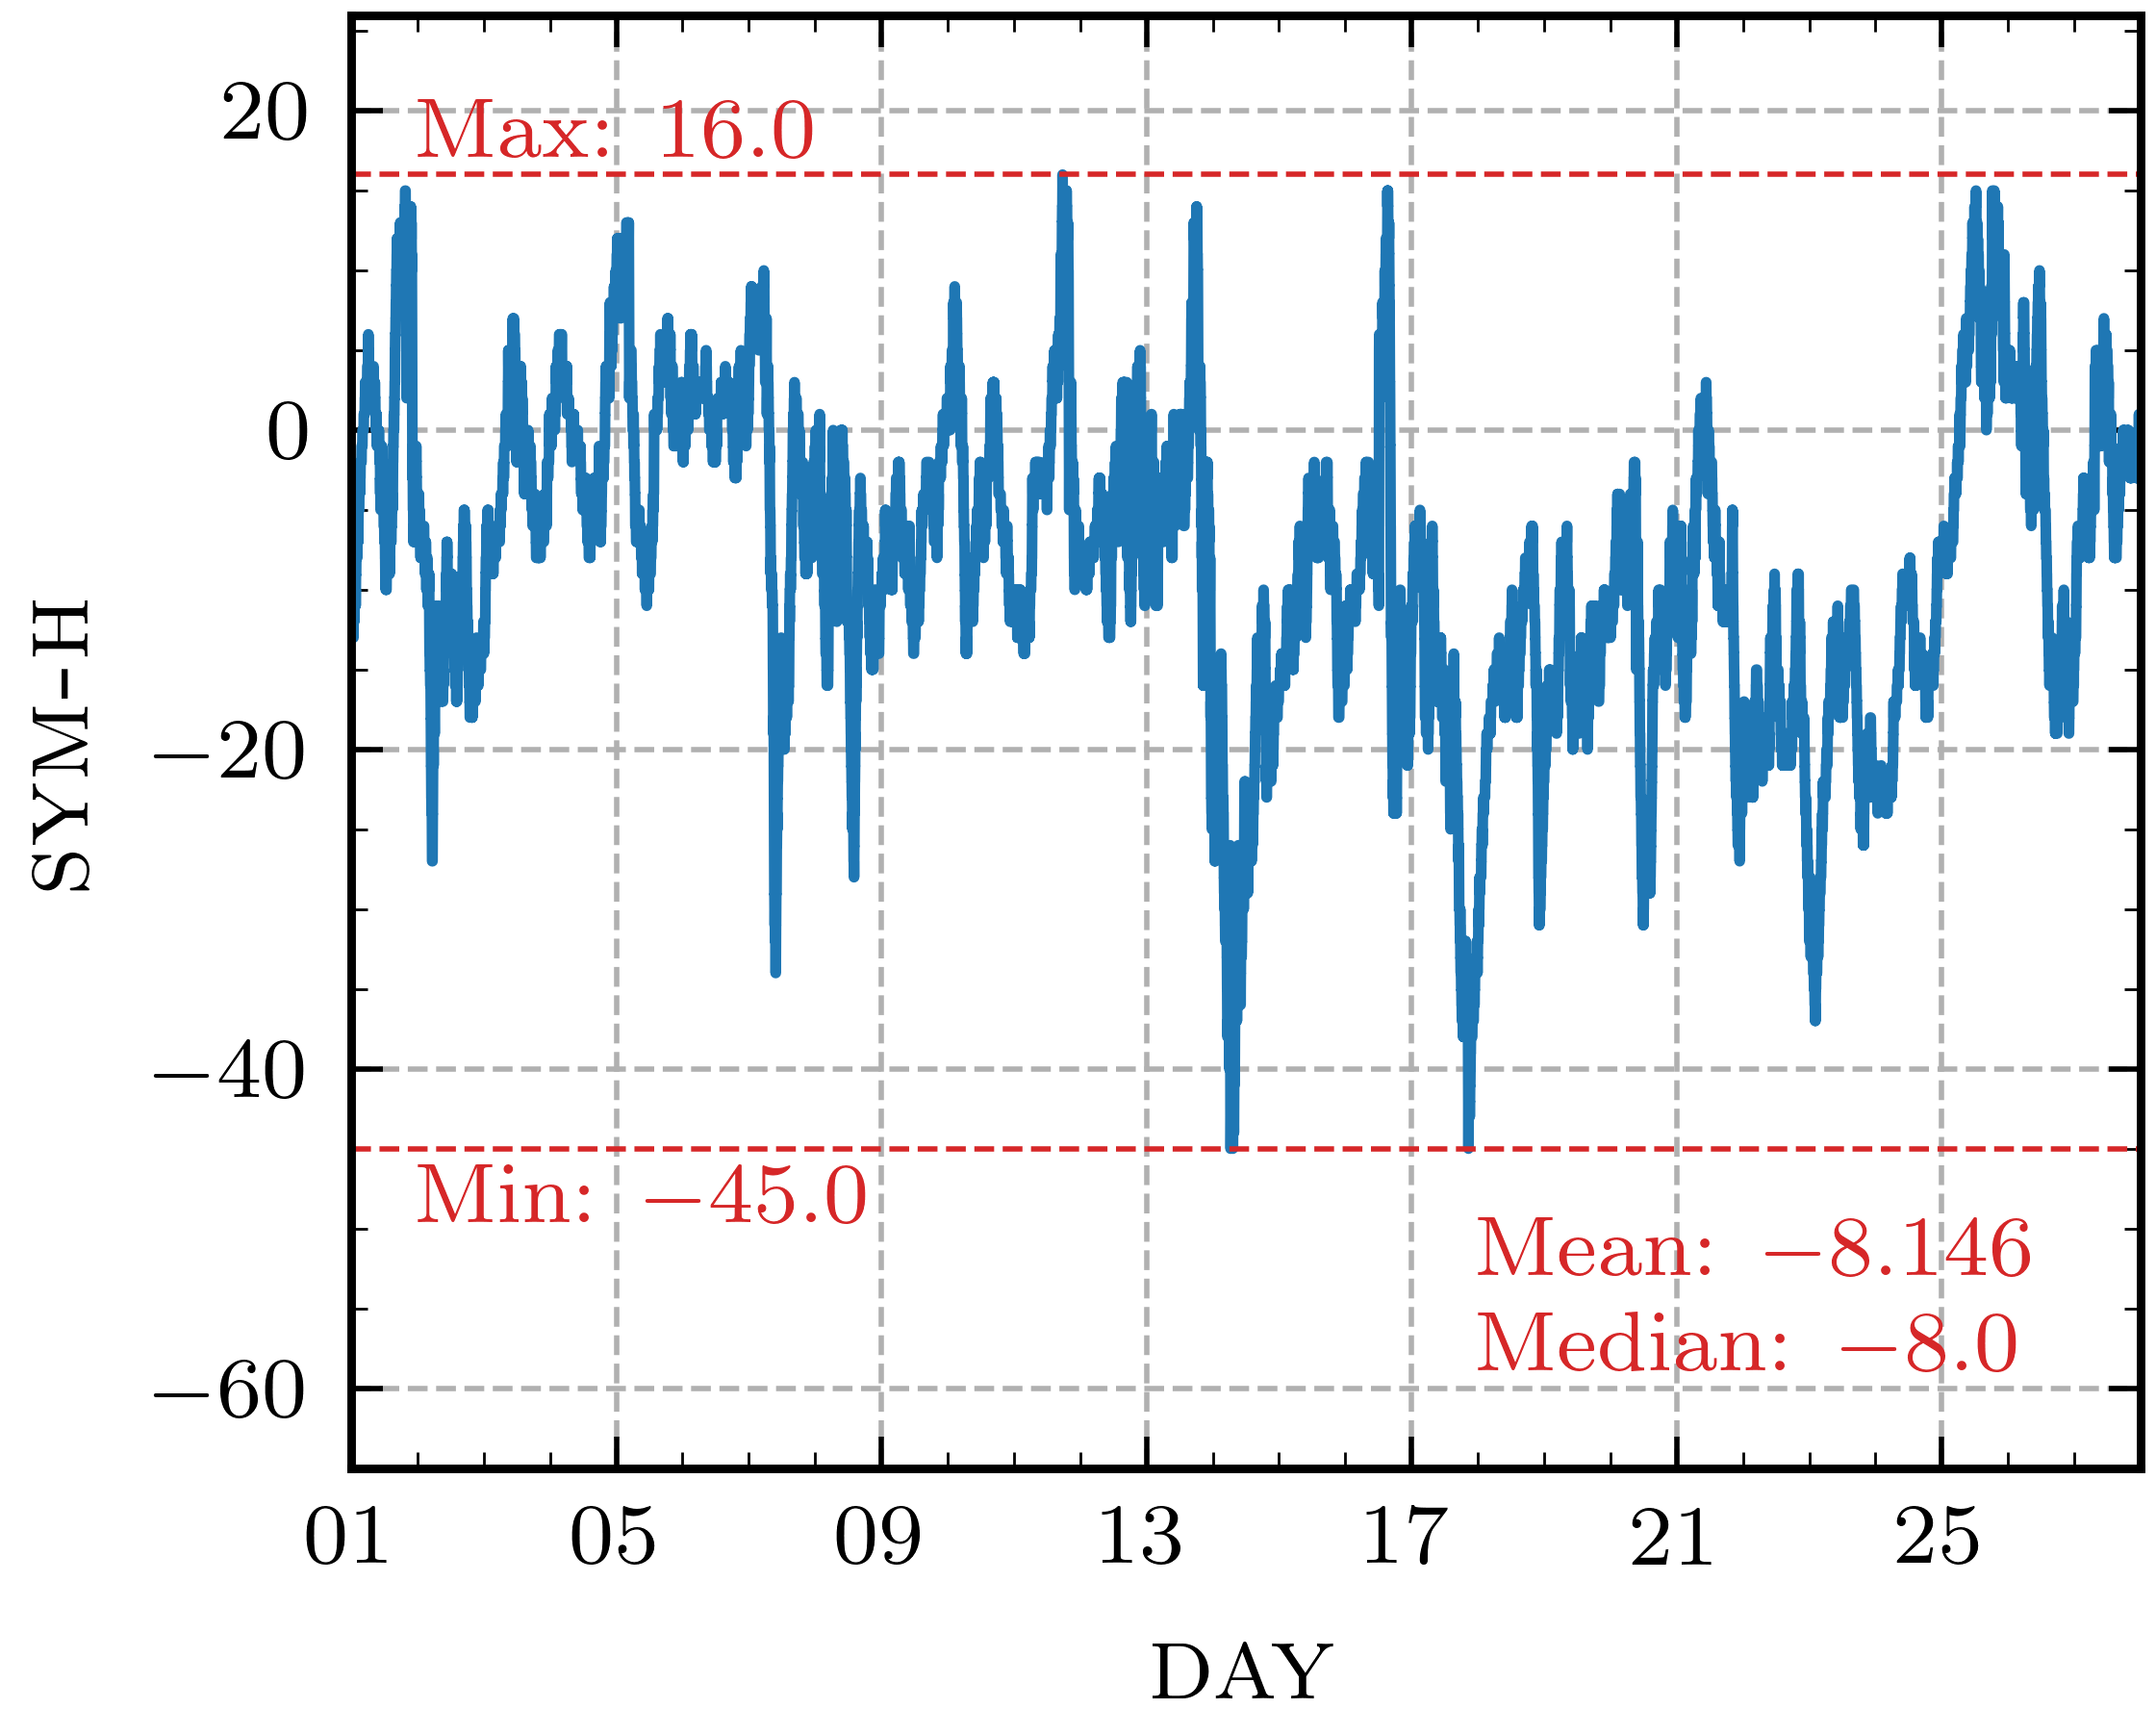

In [6]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel(r'\textsc{day}')
ax.set_ylabel(r'\textsc{sym-h}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlim(datetime.date(2013, 2, 1), datetime.date(2013, 2, 28))
ax.set_ylim(df['SYM-H'].min()-20, df['SYM-H'].max()+10)

# Plot data
ax.plot(df['Timestamp'], df['SYM-H'], color='tab:blue', ls='-', lw=1)

# Indicate statistics
ax.plot(ax.get_xlim(), [df['SYM-H'].max(), df['SYM-H'].max()],
        color='tab:red', ls='--', lw=0.5)
ax.text(x=datetime.date(2013, 2, 2), y=df['SYM-H'].max()+1,
        s=f'Max: {add_latex_minus(round(df["SYM-H"].max(), 3))}',
        color='tab:red')

ax.plot(ax.get_xlim(), [df['SYM-H'].min(), df['SYM-H'].min()],
        color='tab:red', ls='--', lw=0.5)
ax.text(x=datetime.date(2013, 2, 2), y=df['SYM-H'].min()-1,
        va='top', s=f'Min: {add_latex_minus(round(df["SYM-H"].min(), 3))}',
        color='tab:red')

ax.text(x=datetime.date(2013, 2, 18), y=df['SYM-H'].min()-8,
        s=f'Mean: {add_latex_minus(round(df["SYM-H"].mean(), 3))}',
        color='tab:red')
ax.text(x=datetime.date(2013, 2, 18), y=df['SYM-H'].min()-14,
        s=f'Median: {add_latex_minus(round(df["SYM-H"].median(), 3))}',
        color='tab:red')

# ax.legend(loc='upper right', framealpha=0)
# fig.savefig('../images/tp2_fig1.pdf')
plt.show()

## Preparación de datos

In [7]:
def select_interval(df: pd.DataFrame, init_date: str,
                    end_date: str) -> pd.DataFrame:
    """
    This function selects a specific time interval of the column 'Timestamp'
    of a given dataframe.

    :param df: Pandas dataframe that must contain the column 'Timestamp'.
    :param init_date: Initial date.
    :param end_date: End date.
    :return: A copy of the original dataframe with the data of the selected
             interval.
    """
    # Check if 'Timestamp' is in dataframe
    if 'Timestamp' not in list(df.columns):
        raise Exception("'Timestamp' not found in dataframe columns.")

    df_reduced = df.loc[(df['Timestamp'] >= init_date)
                        & (df['Timestamp'] <= end_date)]
    return df_reduced

In [8]:
df_reduced = select_interval(df, '2013-02-01', '2013-02-10')

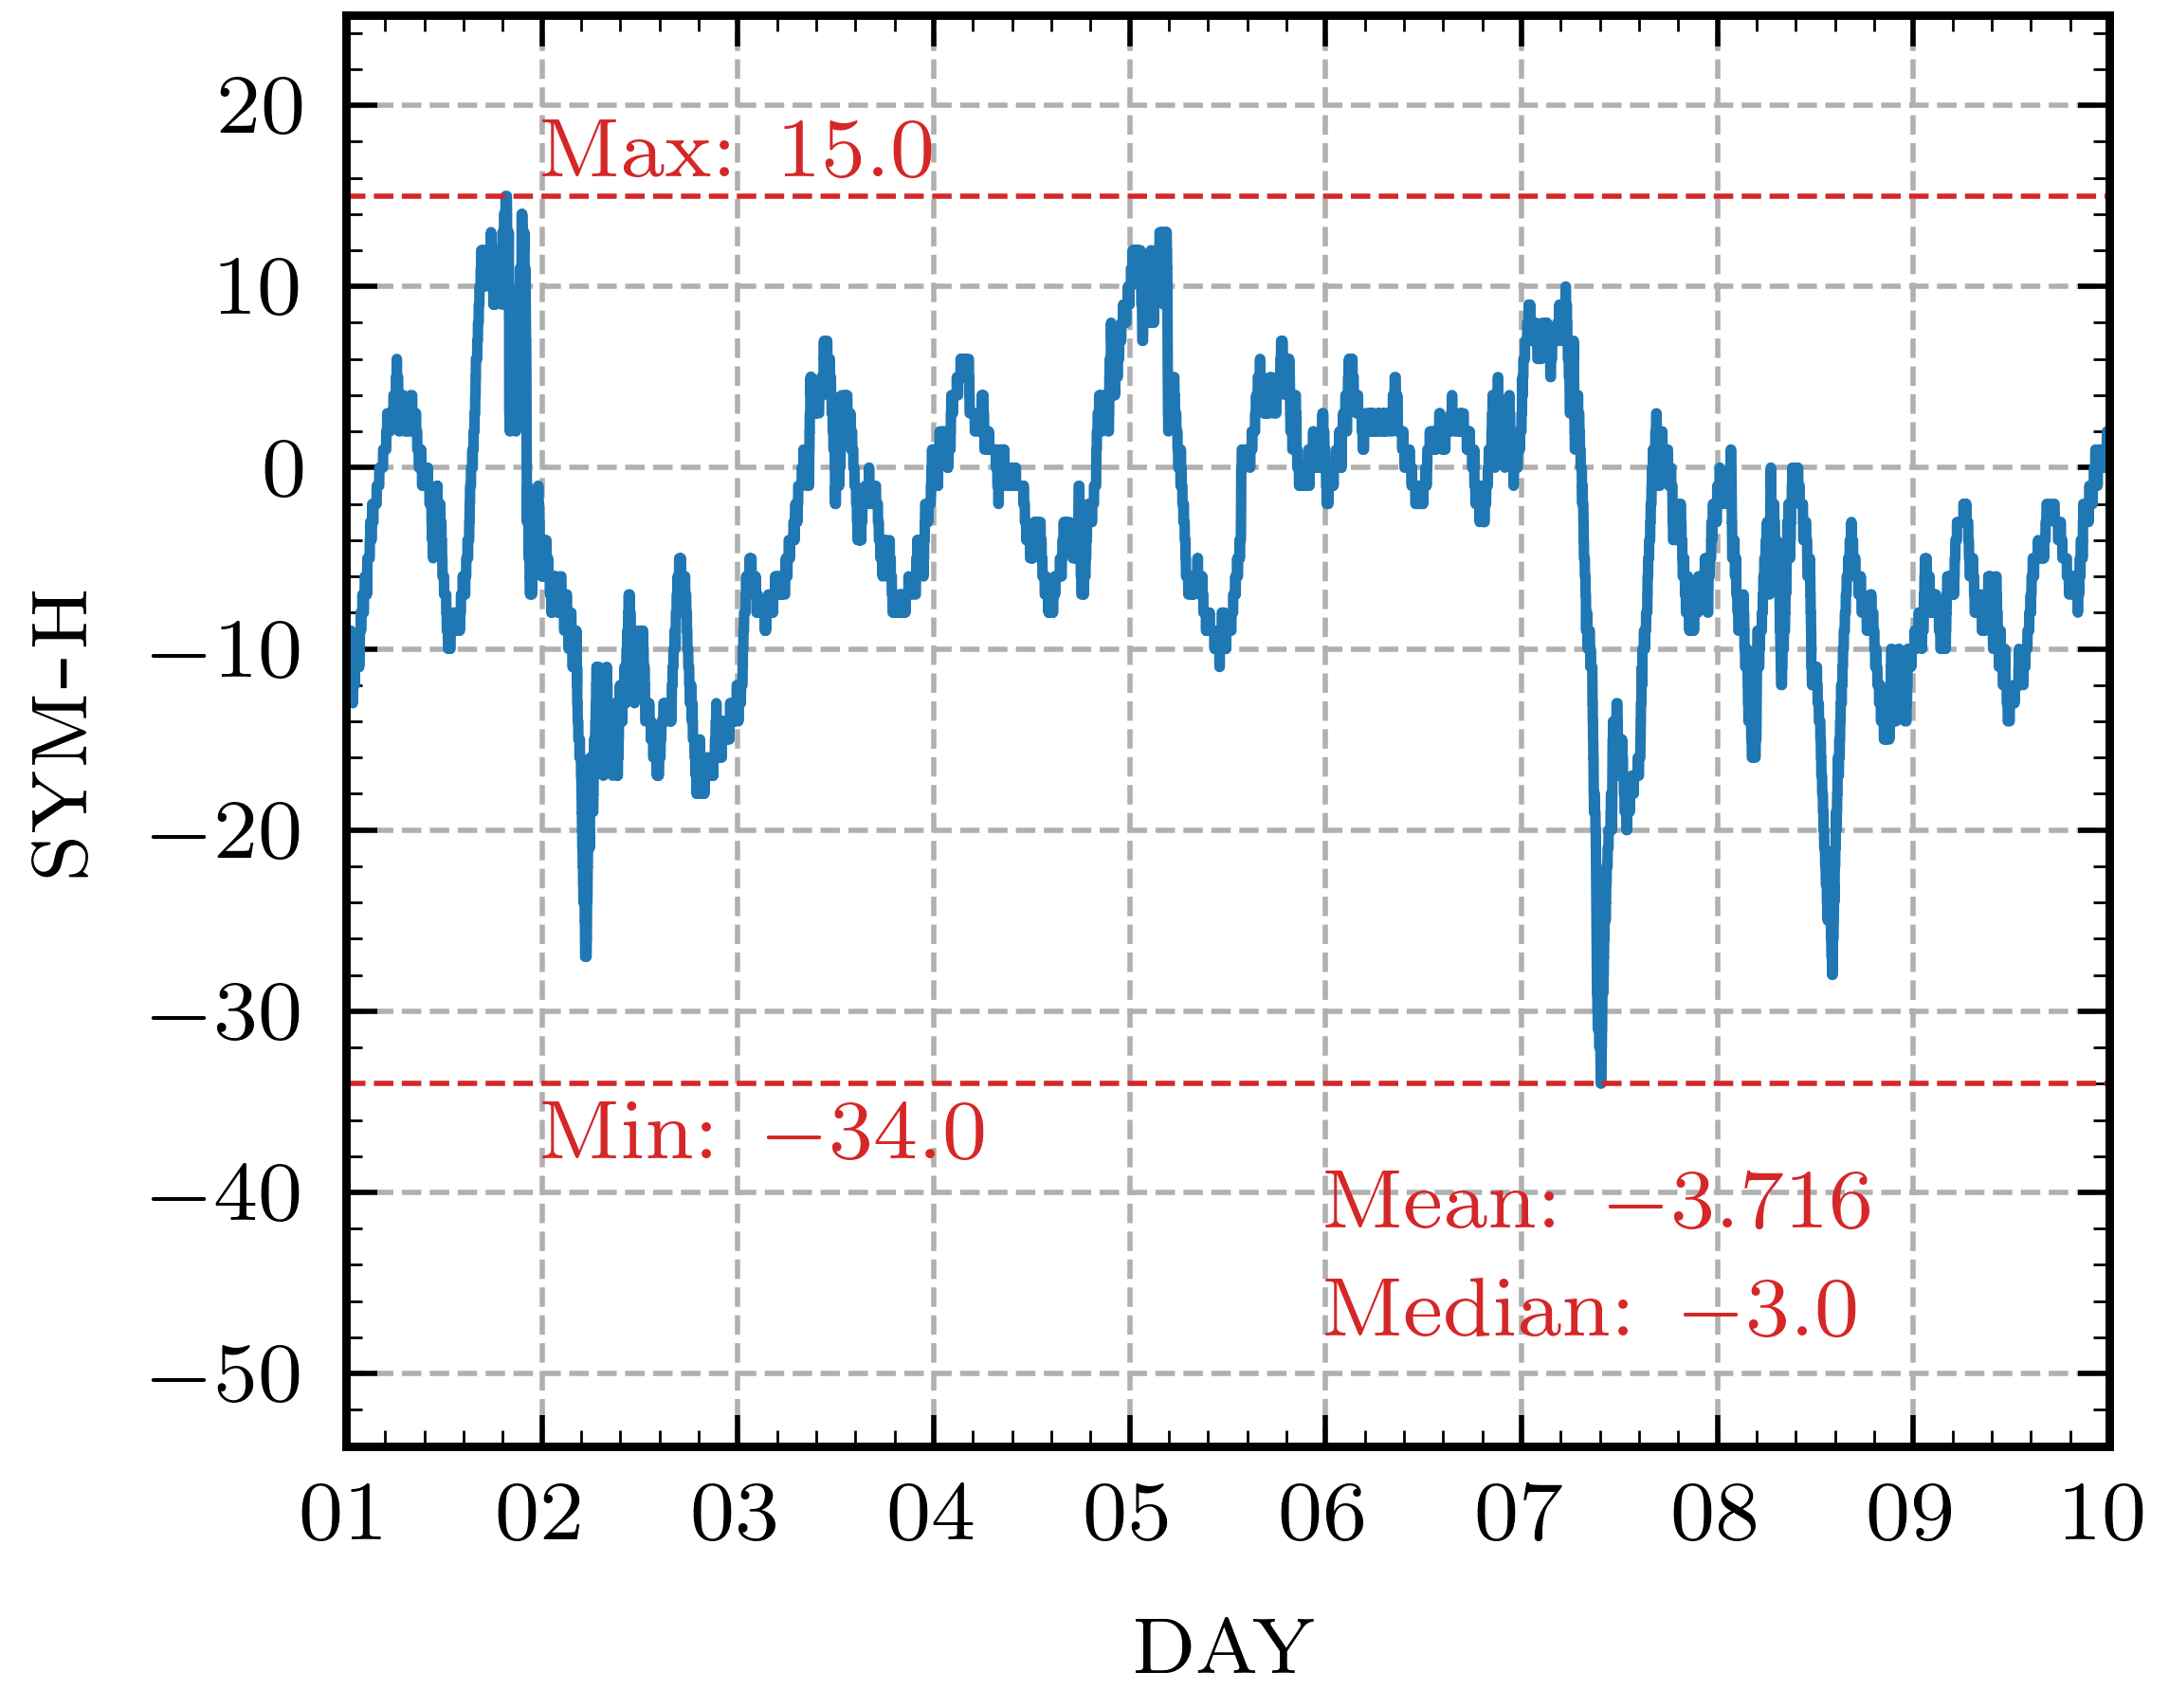

In [9]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel(r'\textsc{day}')
ax.set_ylabel(r'\textsc{sym-h}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
ax.set_xlim(datetime.date(2013, 2, 1), datetime.date(2013, 2, 10))
ax.set_ylim(df_reduced['SYM-H'].min()-20, df_reduced['SYM-H'].max()+10)

# Plot data
ax.plot(df_reduced['Timestamp'], df_reduced['SYM-H'],
        color='tab:blue', ls='-', lw=1)

# Indicate statistics
ax.plot(ax.get_xlim(), [df_reduced['SYM-H'].max(), df_reduced['SYM-H'].max()],
        color='tab:red', ls='--', lw=0.5)
ax.text(x=datetime.date(2013, 2, 2),
        y=df_reduced['SYM-H'].max()+1,
        s=f'Max: {add_latex_minus(round(df_reduced["SYM-H"].max(), 3))}',
        color='tab:red')

ax.plot(ax.get_xlim(), [df_reduced['SYM-H'].min(), df_reduced['SYM-H'].min()],
        color='tab:red', ls='--', lw=0.5)
ax.text(x=datetime.date(2013, 2, 2),
        y=df_reduced['SYM-H'].min()-1, va='top',
        s=f'Min: {add_latex_minus(round(df_reduced["SYM-H"].min(), 3))}',
        color='tab:red')

ax.text(x=datetime.date(2013, 2, 6),
        y=df_reduced['SYM-H'].min()-8,
        s=f'Mean: {add_latex_minus(round(df_reduced["SYM-H"].mean(), 3))}',
        color='tab:red')
ax.text(x=datetime.date(2013, 2, 6),
        y=df_reduced['SYM-H'].min()-14,
        s=f'Median: {add_latex_minus(round(df_reduced["SYM-H"].median(), 3))}',
        color='tab:red')

# ax.legend(loc='upper right', framealpha=0)
# fig.savefig('../images/tp2_fig2.pdf')
plt.show()

## Ingeniería de datos

### ¿Hay datos inválidos?

In [10]:
np.sum(df == np.nan)

Timestamp    0
SYM-H        0
dtype: int64

## Preprocesamiento de datos

No hay necesidad de escribir una nueva función para separar los datos ya que se puede usar la incluida de ```scikit-learn``` para esto.

In [11]:
data_train, data_test = train_test_split(df_reduced['SYM-H'],
                                         test_size=TEST_SIZE,
                                         shuffle=False)

A continuación se inicia el escalador y se lo entrena usando los datos de entrenamiento.

In [12]:
scaler = MinMaxScaler()
data_train = data_train.to_numpy().reshape(-1, 1)
data_train_scaled = scaler.fit_transform(data_train)

In [13]:
data_test = data_test.to_numpy().reshape(-1, 1)
# Use the scaler trained with the train data
data_test_scaled = scaler.transform(data_test)

In [14]:
def split_sequence(sequence: np.ndarray, n_steps_in: int,
                   n_steps_out: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates the sliding windows for sequence.

    :param sequence: A sequence of data in which the sliding window will be
                     computed.
    :param n_steps_in: The number of input steps for training.
    :param n_steps_out: The number of output steps for testing.
    :return: Returns a tuple of np.ndarray with the stored subsequences.
    """
    x, y = [], []
    for i in range(len(sequence)):
        end_idx = i + n_steps_in
        out_end_idx = end_idx + n_steps_out
        if out_end_idx > len(sequence):
            break
        seq_x = sequence[i:end_idx]
        seq_y = sequence[end_idx:out_end_idx]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

In [15]:
# Define sliding window
x, y = split_sequence(data_train_scaled,
                      n_steps_in=N_STEPS_IN,
                      n_steps_out=N_STEPS_OUT)

## Modelado

In [16]:
model = Sequential()

model.add(Dense(units=N_NEURONS,
                activation=ACTIVATION_FUNCTION,
                input_dim=N_STEPS_IN))

model.add(Dense(units=N_NEURONS,
                activation=ACTIVATION_FUNCTION,
                input_dim=N_STEPS_IN))

model.add(Dense(units=N_NEURONS,
                activation=ACTIVATION_FUNCTION,
                input_dim=N_STEPS_IN))

model.add(Dense(units=N_STEPS_OUT))

model.compile(optimizer=OPTIMIZER, loss=LOSS_FUNCTION)

history = model.fit(x, y, epochs=N_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=VERBOSE_TYPE)

2022-08-31 16:58:50.967470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-31 16:58:50.967509: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-31 16:58:50.967533: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neuromancer): /proc/driver/nvidia/version does not exist
2022-08-31 16:58:50.967810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


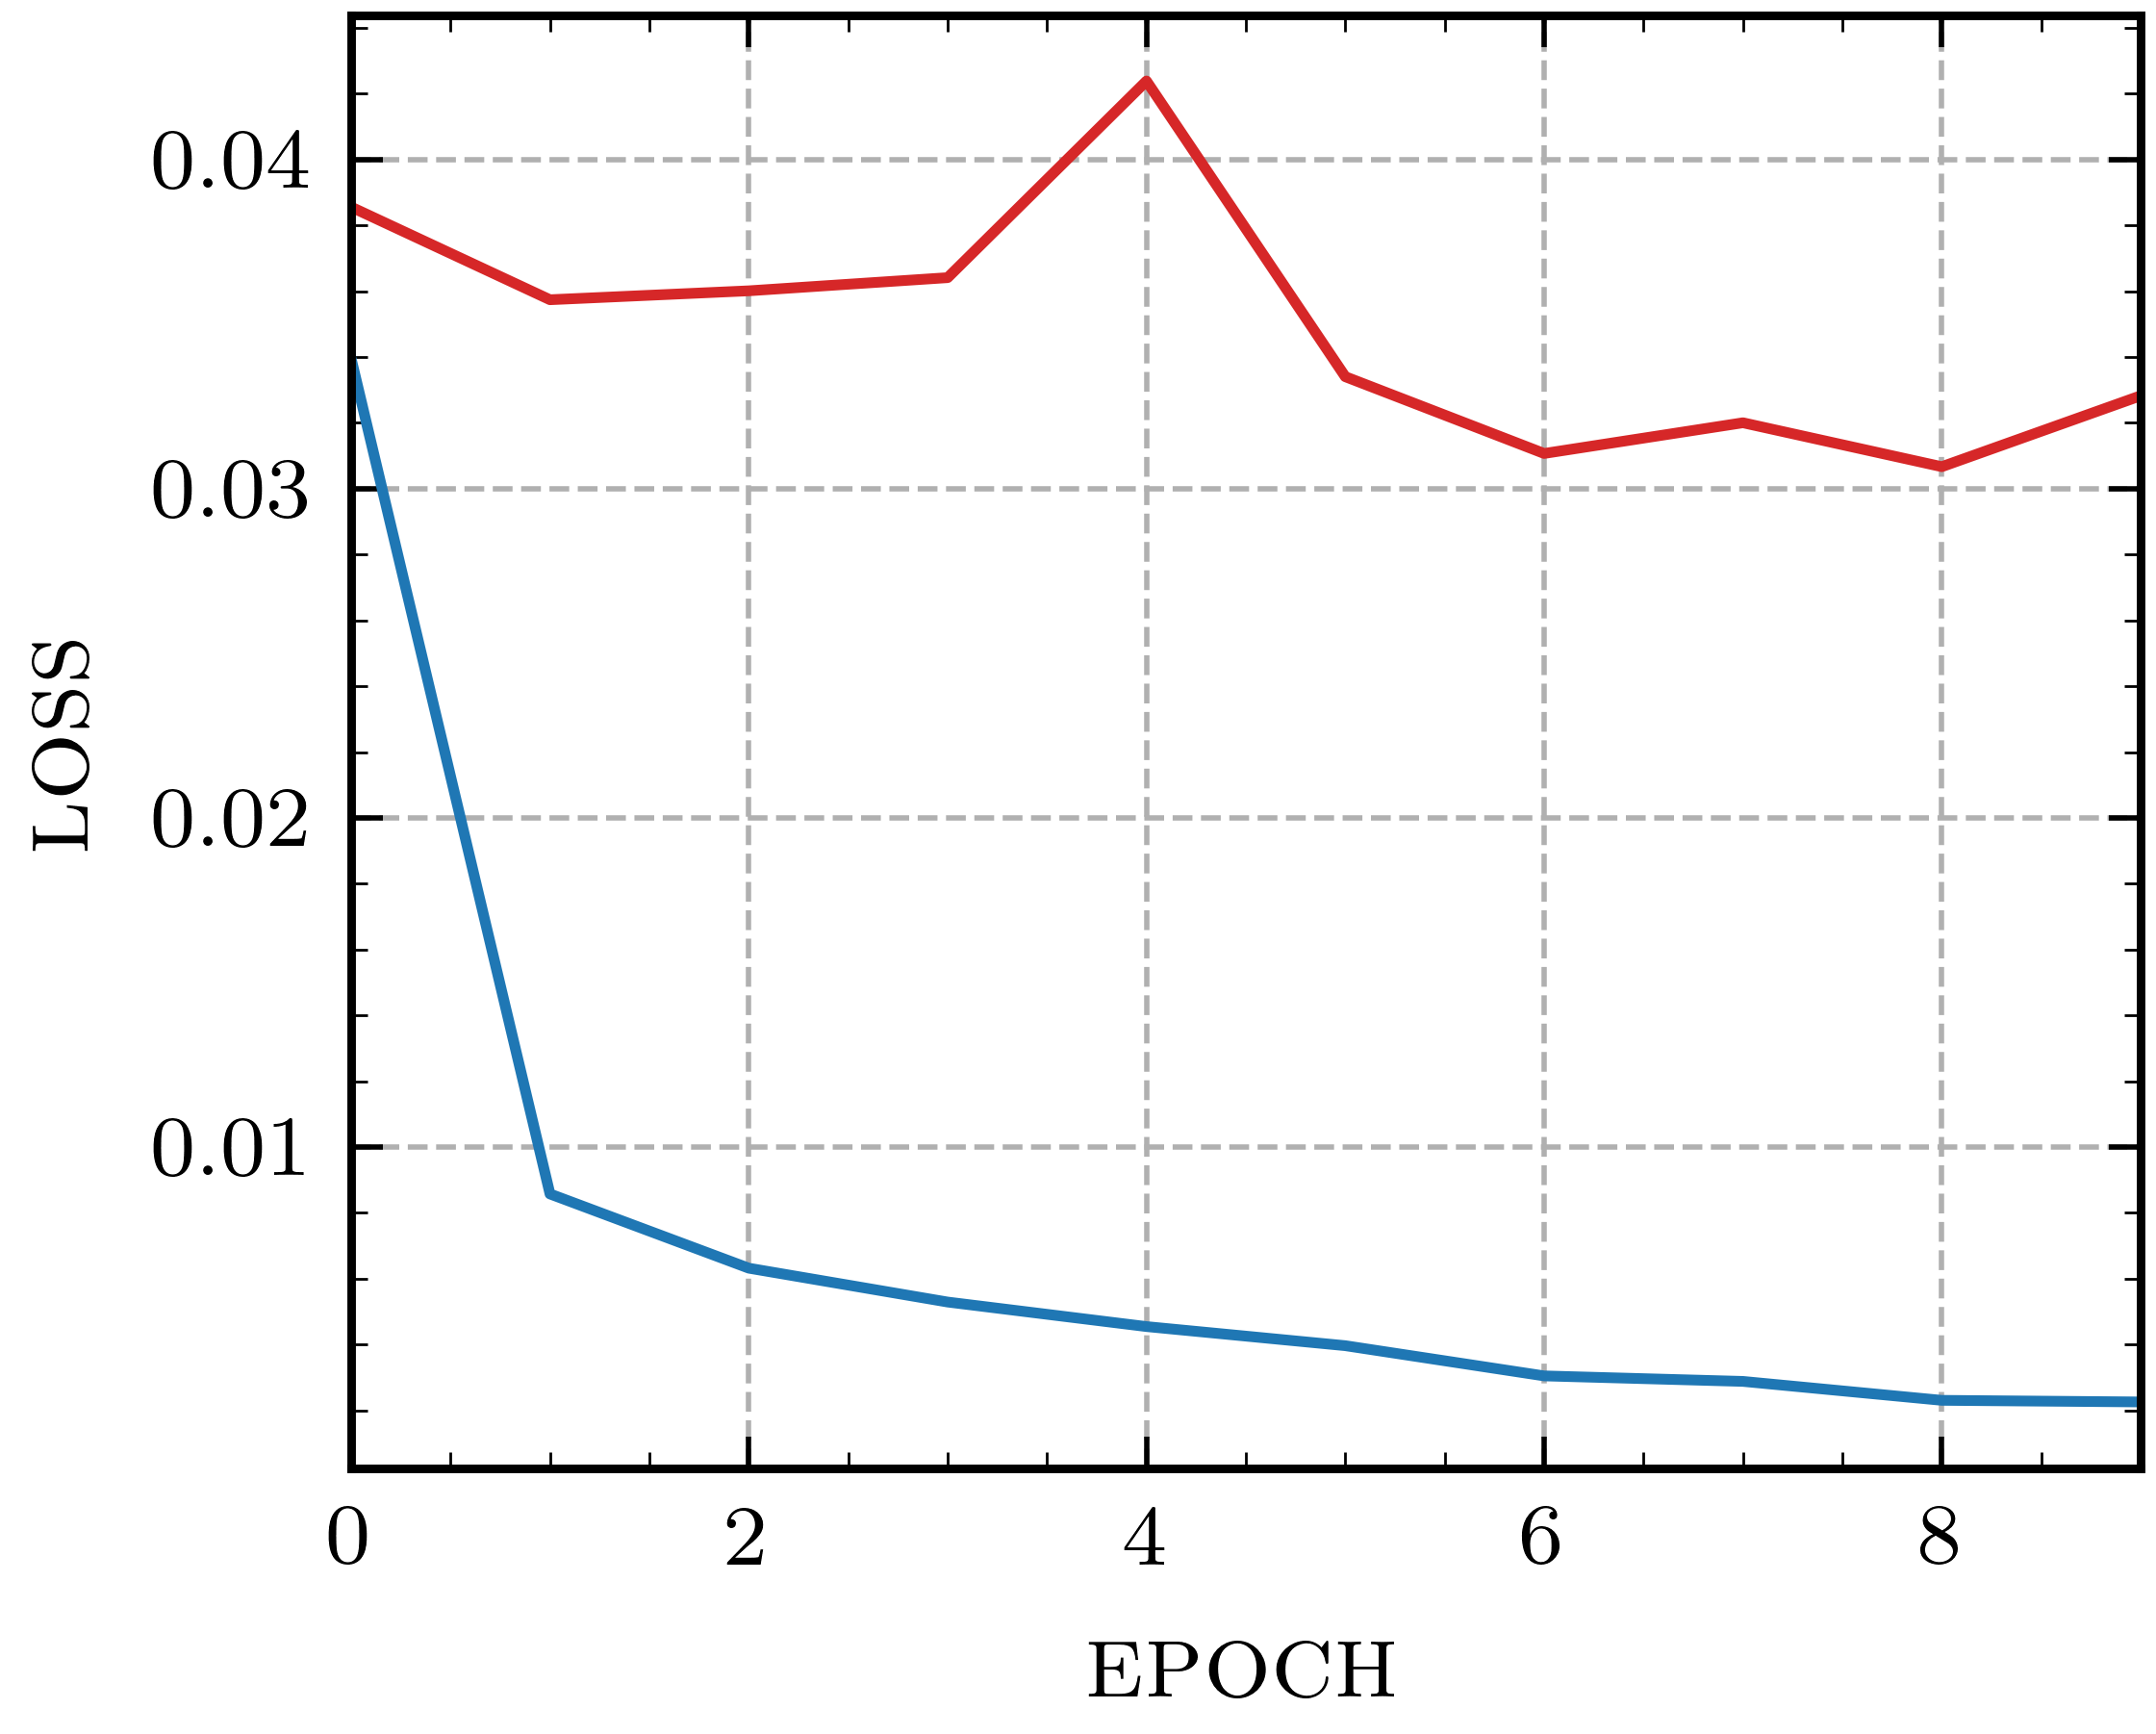

In [17]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
ax.set_xlabel(r'\textsc{epoch}')
ax.set_xlim(0, N_EPOCHS-1)
# ax.set_ylim(0, ax.get_ylim()[1])

ax.set_ylabel(r'\textsc{loss}')
ax.plot(history.history['loss'],
        color='tab:blue', ls='-', lw=1)
ax.plot(history.history['val_loss'],
        color='tab:red', ls='-',  lw=1, label='Validation')

# fig.savefig('../images/tp2_fig3.pdf')
plt.show()

## Predicción y validación

In [18]:
y_hat1 = model.predict(data_train_scaled[-N_STEPS_IN:].reshape(1, -1))
mse = mean_squared_error(y_hat1, data_test_scaled[0:N_STEPS_OUT].reshape(1, -1))
print(mse)

1/1 [==============================] - 0s 78ms/step
0.04208225232426812


In [19]:
print(y_hat1)
y_pred = scaler.inverse_transform(y_hat1)
print(y_pred)

[[0.35406202 0.34013844 0.37489852 0.3564314  0.34113312 0.35302022
  0.36557344 0.3187594  0.34487733 0.3857021  0.3468916  0.36813125
  0.3661039  0.37095866 0.3106192  0.3582301  0.368227   0.39363527
  0.3594358  0.34008673 0.3651916  0.3614263  0.33843148 0.354831
  0.35976323 0.37106347 0.39642954 0.38303122 0.391824   0.3633696
  0.3605481  0.3631435  0.4016228  0.34799936 0.3873616  0.3769438
  0.3521351  0.41891563 0.3858513  0.38712224 0.38719577 0.3496357
  0.3480824  0.37399784 0.3848228  0.39459133 0.410982   0.37515134
  0.38448796 0.40970442 0.34612378 0.37693238 0.3717073  0.38522035
  0.37886974 0.3501623  0.3691273  0.3935124  0.36681992 0.35331464
  0.39647216 0.40422994 0.37521198 0.3729085  0.41204807 0.3610263
  0.3858119  0.36103347 0.37340957 0.3453192  0.36391065 0.36236727
  0.40690812 0.41031677 0.42098883 0.37326863 0.41955057 0.3888499
  0.39908463 0.42026192 0.3766502  0.44207367 0.4406688  0.41845965
  0.38045293 0.35138613 0.43158486 0.404386   0.4263367

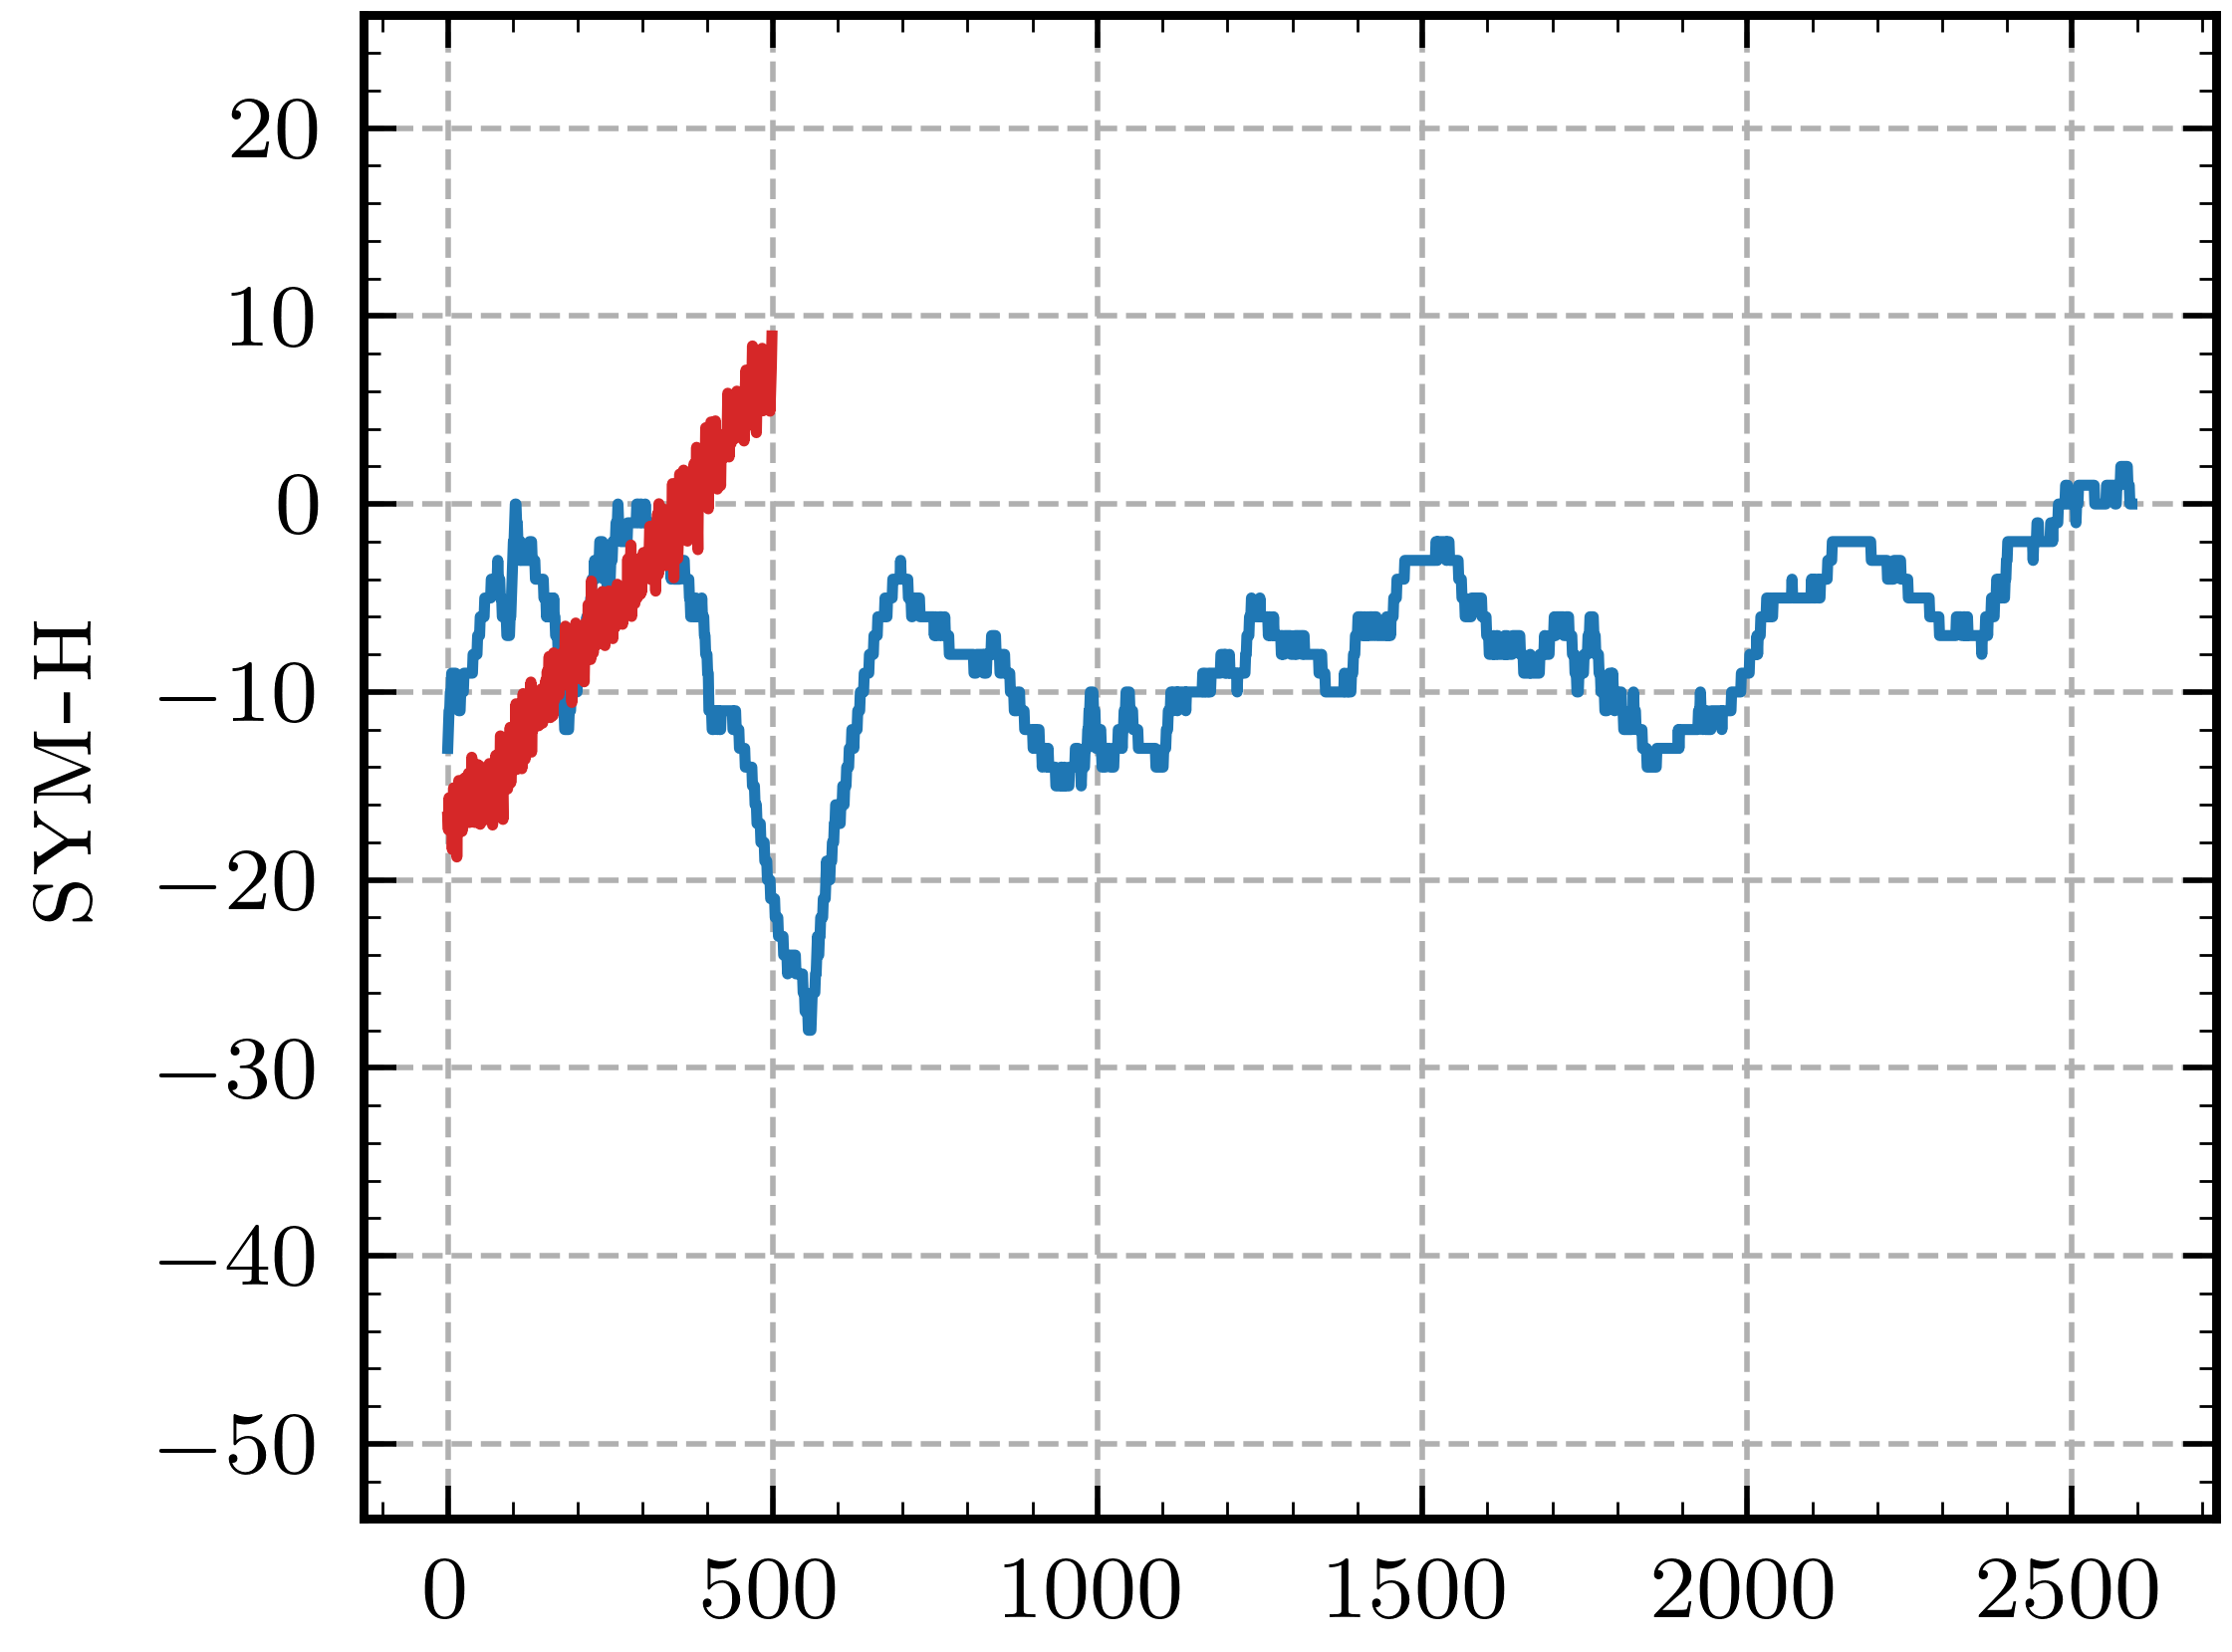

In [20]:
fig = plt.figure(facecolor='white')
gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)

ax.label_outer()
ax.tick_params(which='both', direction="in")
ax.set_axisbelow(True)
ax.grid(True, linestyle='--', lw=.5)
ax.minorticks_on()
# ax.set_xlabel(r'\textsc{day}')
ax.set_ylabel(r'\textsc{sym-h}')
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
# ax.set_xlim(datetime.date(2013, 2, 1), datetime.date(2013, 2, 28))
ax.set_ylim(df_reduced['SYM-H'].min()-20, df['SYM-H'].max()+10)

# Plot data
ax.plot(np.array(df_reduced['SYM-H'])[-len(data_test):],
        color='tab:blue', ls='-', lw=1)
ax.plot(y_pred.flatten(),
        color='tab:red', ls='-', lw=1)

# ax.legend(loc='upper right', framealpha=0)
# fig.savefig('../images/tp2_fig1.pdf')
plt.show()

In [21]:
# def walk_forward(data: np.ndarray, n_test: int, n_steps_in: int) -> np.ndarray:
#     data1 = data.copy()
#     for i in range(n_test):
#         y_hat = model.predict(data1[-n_steps_in:].reshape(1, -1))[0, 0]
#         data1 = np.vstack((data1, y_hat.reshape(1, -1)))
#     return data1

In [22]:
# y_hat = walk_forward(data_train_scaled, len(data_test_scaled), N_STEPS_IN)

In [23]:
# y_pred = scaler.inverse_transform(y_hat)

In [24]:
# mse = mean_squared_error(y_pred, df_reduced['SYM-H'])
# print(mse)

In [25]:
# fig = plt.figure(facecolor='white')
# gs = fig.add_gridspec(ncols=1, nrows=1, hspace=0, wspace=0)
# ax = gs.subplots(sharex=True, sharey=True)
#
# ax.label_outer()
# ax.tick_params(which='both', direction="in")
# ax.set_axisbelow(True)
# ax.grid(True, linestyle='--', lw=.5)
# ax.minorticks_on()
# # ax.set_xlabel(r'\textsc{day}')
# ax.set_ylabel(r'\textsc{sym-h}')
# # ax.xaxis.set_major_formatter(mdates.DateFormatter('%d'))
# # ax.set_xlim(datetime.date(2013, 2, 1), datetime.date(2013, 2, 28))
# ax.set_ylim(df_reduced['SYM-H'].min()-20, df['SYM-H'].max()+10)
#
# # Plot data
# ax.plot(np.array(df_reduced['SYM-H'])[-len(data_test):],
#         color='tab:blue', ls='-', lw=1)
# ax.plot(y_pred[-len(data_test):],
#         color='tab:red', ls='-', lw=1)
#
# # ax.legend(loc='upper right', framealpha=0)
# # fig.savefig('../images/tp2_fig1.pdf')
# plt.show()